# Modélisation avec Random Forest

In [1]:
conda install python-graphviz

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import fonctions as f

In [3]:
#on divise la base en partie test et en partie entraînement
data= f.pd.read_csv("dataMod.csv", index_col =["DATE"])
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# On divisie la base train en une partie contenant les variables explicatives et la variable d'interêt
x_train=train.drop('TM',axis=1)
TM_train=train['TM']
# On divisie la base test en une partie contenant les variables explicatives et la variable d'interêt
x_test=test.drop('TM',axis=1)
TM_test=test['TM']

Les statistiques descriptives ont montré de fortes corrélations entre la variable d'études "TM": Température moyenne et les autres variables liées à la température telles que "TN": température minimale, "TX": Température maximale,"TAMPLI": Amplitude thermique(écart entre température maximale et miniamle), "TNTXM": Moyenne de la température minimale et maximale sur une période donnée,"TMNX": Moyenne des températures minimales et maximales,"TSVM": Température moyenne au sol.

In [4]:
# On divisie la base train en une partie contenant les variables explicatives et la variable d'interêt et on supprime les variables de températures
x_train2=train.drop(columns=['TMNX', 'TNTXM','TM',"TX","TN","TAMPLI","TSVM"])
TM_train=train['TM']
# On divisie la base test en une partie contenant les variables explicatives et la variable d'interêt
x_test2=test.drop(columns=['TMNX', 'TNTXM','TM',"TX","TN","TAMPLI","TSVM"])
TM_test=test['TM']


In [5]:
x_train2.shape,x_test2.shape,TM_train.shape,TM_test.shape

((817, 23), (205, 23), (817,), (205,))

In [6]:
#recherche des meilleurs paramètres 
param_dist = {'n_estimators': f.randint(50,500),# il s’agit du nombre d’arbres dans la forêt
              'max_depth': f.randint(1,20)}#il s’agit de la profondeur maximale des arbres utilisés (le nombre de niveaux dans l’arbre de décision)

# Creation d'un random forest classifier
rf = f.RandomForestRegressor()

# Utilisation de random search pour trouver les meilleurs paramètres
rand_search = f.RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit le random search object avec la data
rand_search.fit(x_train2, TM_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5a2cb8a120>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f5e8733ba40>})

In [14]:
# Création d'une variable pour le meilleur modèle
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 17, 'n_estimators': 469}


In [17]:
#On réalise ainsi la regression
rf2=f.RandomForestRegressor(max_depth=rand_search.best_params_["max_depth"], n_estimators=rand_search.best_params_["n_estimators"])
rf2.fit(x_train2, TM_train)

RandomForestRegressor(max_depth=17, n_estimators=469)

# Future importance

Pour évaluer dans quelle mesure chaque variable explicative (ou caractéristique) contribue à la prédiction d'un modèle. Elle permet de comprendre quelles variables influencent le plus les décisions du modèle.

In [18]:
# Affficher les futures importance

f.pd.DataFrame(rf2.feature_importances_,
              index = x_train2.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

,importance
ETPGRILLE,0.697313
DG,0.205177
RR,0.009404
UN,0.008368
FFM,0.007050
HUX,0.006630
DHUMI80,0.006189
HTN,0.006082
HUN,0.006024
DXI,0.005944


Ainsi les variables les plus importantes sont EPTGRILLE: Evapotranspiration mensuelle, DG. La variable la moins importante est "NEIGTOT06".

Text(0.5, 1.0, 'Variable Importances')

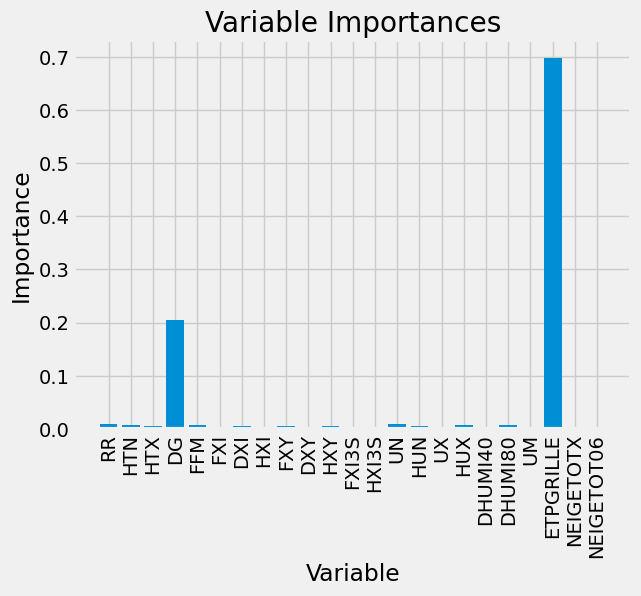

In [19]:
importances = list(rf2.feature_importances_)
feature_list = list(x_train2.columns)

# Set the style
f.plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
f.plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
f.plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
f.plt.ylabel('Importance')
f.plt.xlabel('Variable')
f.plt.title('Variable Importances')

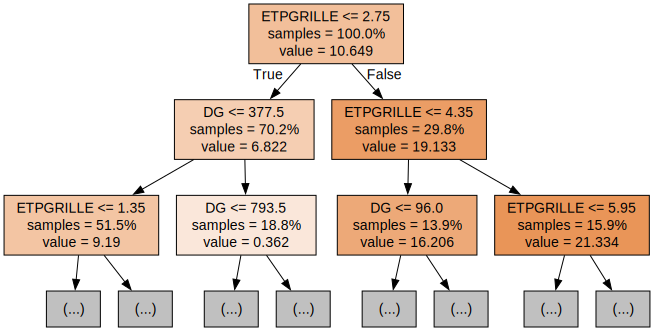

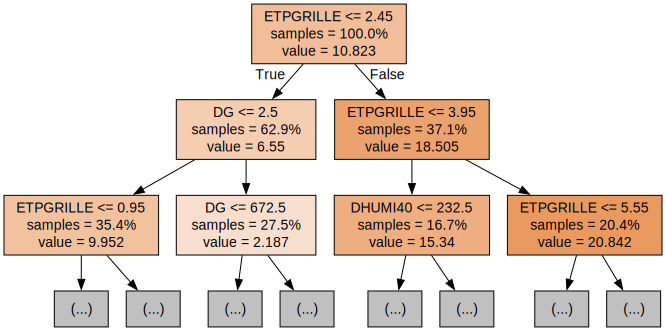

In [20]:
#Visualisation des 2 premiers arbres
for i in range(2):
    tree = rf2.estimators_[i]
    dot_data = f.export_graphviz(tree,
                               feature_names=x_train2.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = f.graphviz.Source(dot_data)
    display(graph)

# Evaluation du modèle

In [23]:
print('Mean Absolute Error:',f.mean_absolute_error(TM_test, predict))

mape = f.mean_absolute_percentage_error(TM_test, predict) * 100

# Calcul de R²
r2 = f.r2_score(TM_test, predict)

print(f"MAPE: {mape}%")
print(f"R²: {r2}")

Mean Absolute Error: 2.2639508794595633
MAPE: 19.134879197063594%
R²: 0.615302149991653


In [25]:
# On ajoute les dates aux prédictions
predict_data= f.pd.DataFrame(data = {'date': TM_test.index, 'prediction': predict})
predict_data.head()

,date,prediction
0,2024-04-10,10.856817
1,2024-04-11,7.211727
2,2024-04-12,14.101389
3,2024-04-13,17.073348
4,2024-04-14,15.451812


Text(0.5, 1.0, 'Actual and Predicted Values')

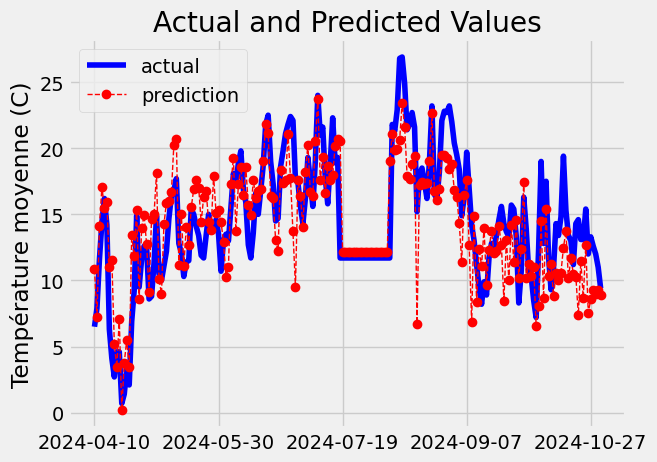

In [26]:
from matplotlib.ticker import MaxNLocator
#plot des vraies valeurs
#
f.plt.plot(TM_test.index, TM_test, 'b-', label = 'actual')


# Plot des valeurs prédites
f.plt.plot(predict_data['date'], predict_data['prediction'], 'ro',linestyle="--", linewidth=1, label = 'prediction')

# Limiter le nombre de ticks à 5 maximum
f.plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
#plt.xticks(rotation="vertical") 
f.plt.legend()
# Graph labels
f.plt.ylabel('Température moyenne (C)')
f.plt.title('Actual and Predicted Values')